# Model evaluation

[![colab badge](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mcallaghan/NLP-climate-science-tutorial-CCAI/blob/main/C_evaluation.ipynb)

Now we know how to build a model, we need to 
- choose the best model, 
- estimate our chosen model's performance, 
- make predictions for the documents we haven't seen 

First we will look at the basics of evaluation model outputs

## Metrics

When we have labelled data, evaluation works by comparing the labels we gave to the labels the model predicts. The closer the predicted labels are to the true labels, the better our model. **Metrics** quantify different aspects of that closeness, and we'll explore a few of the commonly used ones

### Accuracy

Accuracy is a frequently used metric, because it is very easy to understand and to explain. It simply describes the proportion of predictions which are correct:

$ Accuracy = \frac{CorrectPredictions}{TotalPredictions} $

In [1]:
import os
## If we are running in colab, mount google drive and change into the directory we cloned the repository into
if os.path.exists("/content/"):
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/NLP-climate-science-tutorial-CCAI") 

Mounted at /content/drive


In [2]:
import numpy as np

# Let's examine
y_pred = np.array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0])
y_true = np.array([0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

def calculate_accuracy(y_true, y_pred):
    total_predictions = y_true.size
    correct_predictions = (y_pred==y_true).sum()
    accuracy = correct_predictions / total_predictions
    print(f"{correct_predictions} correct predictions out of {total_predictions} total predictions.\nAccuracy = {accuracy:.0%}")
    
calculate_accuracy(y_true, y_pred)

8 correct predictions out of 10 total predictions.
Accuracy = 80%


This seems pretty good, but because the classes are imbalanced, we could get exactly the same accuracy just by predicting 0 for each sample 

In [3]:
calculate_accuracy(y_true, np.zeros(y_true.size))

8 correct predictions out of 10 total predictions.
Accuracy = 80%


Accuracy only tells a part of the story, and under quite common conditions, this story can be misleading. 

Let's therefore take a look at some other metrics that give us more specific information about how the model performs, and tells us what kinds of mistakes it tends to make how frequently

## Precision and Recall

Predictions can have two types of errors: false positives (where a sample is negative and it is predicted to be positive) & false negatives (where a sample is positive and it is predicted to be negative). Correspondingly there are also two types of correct predictions: true positives & true negatives. In different contexts, these types of errors can have different costs. For example, in health screening applications, false negatives can carry very high costs, as they could result in a serious condition going untreated. Precision and recall are ways of describing the prevalence of each type of error.

### Precision

Precision describes the fraction of samples predicted to be positive that are actually positive. 

$ Precision = \frac{TruePositives}{TruePositives + FalsePositives} $

In other words, if a classifier identifies 100 samples as true, precision tells us how many of those samples are actually true.

### Recall

Recall describes the fraction of positive samples which are identified by the classifier.

$ Recall = \frac{TruePositives}{TruePositives + FalseNegatives} $

In other words, if 100 samples are true, recall tells us how many of those samples our classifier will identify.

## F1

The F1 score is the average of the precision and recall. It can be weighted (in which case it becomes an $ F{\beta} $ score if we value either precision or recall more highly


In [4]:
def calculate_precision(y_true, y_pred):
    tps = (y_true+y_pred==2).sum()
    positive_predictions = (y_pred==1).sum()
    precision = tps / positive_predictions
    print(f"{tps} out of {positive_predictions} predicted positives are actually positive")
    print(f"precision = {precision:.0%}")

# Our predictions achieve a much more modest precision score
calculate_precision(y_true, y_pred)
# Whereas predicting all zeros gives us NA result as the denominator is zero
calculate_precision(y_true, np.zeros(y_true.size))

1 out of 2 predicted positives are actually positive
precision = 50%
0 out of 0 predicted positives are actually positive
precision = nan%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in long_scalars
  after removing the cwd from sys.path.


In [5]:
def calculate_recall(y_true, y_pred):
    tps = (y_true+y_pred==2).sum()
    positive_samples = (y_true==1).sum()
    recall = tps / positive_samples
    print(f"{tps} out of {positive_samples} true samples are identified")
    print(f"recall = {recall:.0%}")

# Recall is also more modest with our predictions
calculate_recall(y_true, y_pred)
# And a prediction of all zeros has zero recall
calculate_recall(y_true, np.zeros(y_true.size))

1 out of 2 true samples are identified
recall = 50%
0 out of 2 true samples are identified
recall = 0%


## Cross-validation

To compare a model's output with the target data, we employ cross-validation to split the data into separate training and validation sets. We'll show how this works on a sample data set with 100 samples

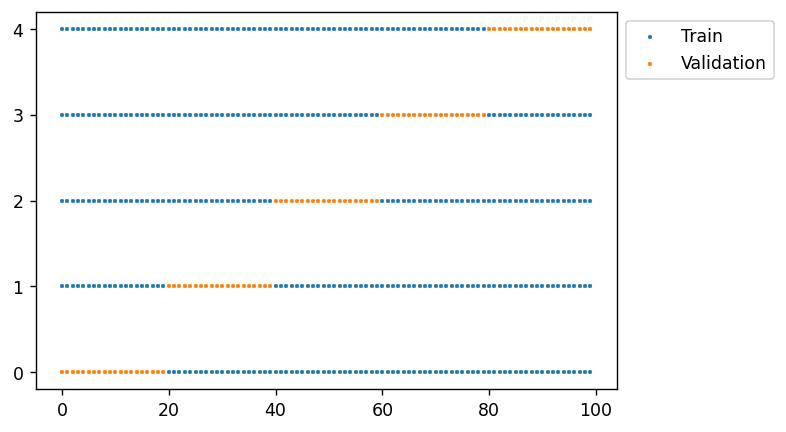

In [6]:
data_ids = np.arange(100)

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
kf = KFold()
fig, ax = plt.subplots(dpi=125)

for i, (train_index, validation_index) in enumerate(kf.split(data_ids)):
    ax.scatter(
        train_index, [i]*train_index.size, 
        color="C0", s=2, label="Train" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        validation_index, [i]*validation_index.size, 
        color="C1", s=2, label="Validation" if i == 0 else "",
        marker="s"
    )
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_yticks(np.arange(i+1))

plt.show()

Each sample is used exactly once for validation. All other data is used for training a classifier, and its predictions for the validation set are compared to the true labels. It is important that the validation data is *never* seen during training.

## Hyperparameter tuning

However, we don't want to just use one specification of a model, when we can potentially improve our results by selecting a specification which performs best on our data. By selecting a specification we mean choosing settings for processing and model set-up, known as **hyperparameters**.

In [7]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, ParameterGrid

# This is the pipeline we used before
pipeline = Pipeline(steps=[
    ("vect", TfidfVectorizer()), 
    ("clf", SVC(probability=True, class_weight="balanced"))
])

# Here we define the parameters, those starting with "vect__" are given as arguments to the vectorizer
# those starting with clf are given as arguments to the classifier

parameters = [
    {
        'vect__max_df': (0.5, 0.8), # This is the maxmimum proportion of documents a term can appear in
        'vect__min_df': (5, 15), # This is the minimum number of documents a term can appear in
        'vect__ngram_range': ((1, 1), (1, 2)),  # these are the possible sizes of the ngrams we tokenize into
        'clf__kernel': ['rbf'], # This is the kernel function https://scikit-learn.org/stable/modules/svm.html#svm-kernels
        'clf__gamma': [1e-3, 1e-4], # Because only the rbf kernel has the gamma parameters, we do this separately
        'clf__C': [1, 1e1, 1e2] # The C parameter (large = risk of overfit, small risk of underfit) https://stats.stackexchange.com/a/159051
    },
    {
        'vect__max_df': (0.5,0.8),
        'vect__min_df': (5, 15),
        'vect__ngram_range': ((1, 1), (1, 2)),  
        'clf__kernel': ['linear'], 
        'clf__C': [1, 1e1, 1e2]
    }
]

# The parameter grid gives us the unique combinations
grid = list(ParameterGrid(parameters))
print(len(grid))
grid[:3]

72


[{'clf__C': 1,
  'clf__gamma': 0.001,
  'clf__kernel': 'rbf',
  'vect__max_df': 0.5,
  'vect__min_df': 5,
  'vect__ngram_range': (1, 1)},
 {'clf__C': 1,
  'clf__gamma': 0.001,
  'clf__kernel': 'rbf',
  'vect__max_df': 0.5,
  'vect__min_df': 5,
  'vect__ngram_range': (1, 2)},
 {'clf__C': 1,
  'clf__gamma': 0.001,
  'clf__kernel': 'rbf',
  'vect__max_df': 0.5,
  'vect__min_df': 15,
  'vect__ngram_range': (1, 1)}]

Now we could do cross-validation for each of these 72 combinations of parameters. However, the performance we achieve on the validation sets would likely be over-optimistic. 

Why?

<br>
<br>
<br>

The hyperparameters would be likely **overfit** to the data we have. Information can leak into the model from the validation data.

One way of dealing with this is to separate a **test** set of data, which is never seen in the hyperparameter tuning procedure



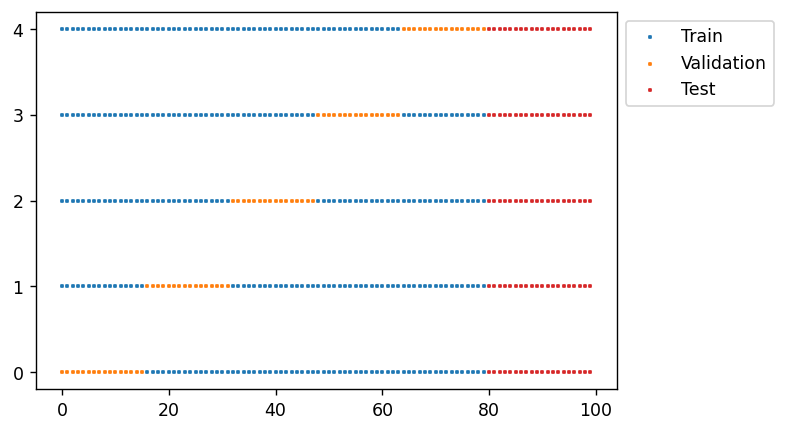

In [8]:
from sklearn.model_selection import train_test_split

# First we split off the test data from what we will be using for cross validation
cv, test = train_test_split(data_ids, shuffle=False, test_size=0.2)

fig, ax = plt.subplots(dpi=125)

# Now we split the cv part into individual training and test sets
kf = KFold()
for i, (train_index, validation_index) in enumerate(kf.split(cv)):
    ax.scatter(
        cv[train_index], [i]*train_index.size, 
        color="C0", s=2, label="Train" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        cv[validation_index], [i]*validation_index.size, 
        color="C1", s=2, label="Validation" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        test, [i]*test.size, 
        color="C3", s=2, label="Test" if i == 0 else "",
        marker="s"
    )
    
ax.legend(bbox_to_anchor=(1,1))
ax.set_yticks(np.arange(i+1))

plt.show()


This is one way of treating the problem that is safe from overfitting. One problem with this approach though, is that the results are highly dependent on our test split. Where data is scarce, and classes are imbalanced, we may have few examples of particular classes in there.

## Nested cross validation

Nested cross validation is another way to separate hyperparameter tuning from estimating the performance of our chosen classifier. In essence we do two steps of cross-validation - one for each task - making sure that the samples used to assess performance are **never** seen during the process of selecting hyperparameters.

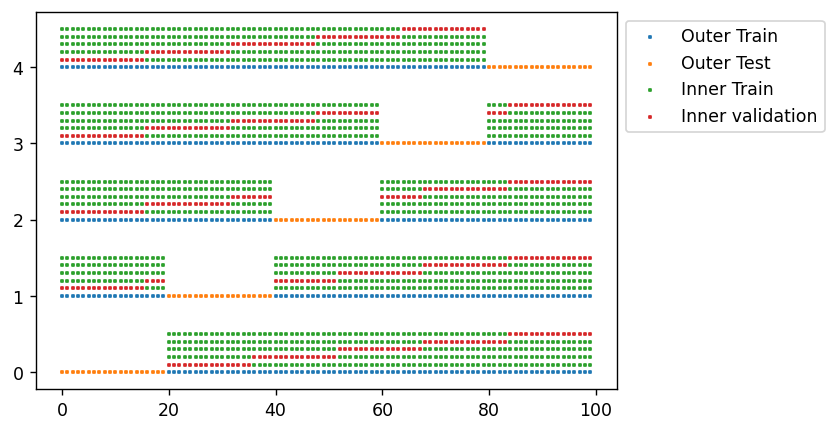

In [9]:
fig, ax = plt.subplots(dpi=125)

outer_fold = KFold()
for i, (outer_train_index, test_index) in enumerate(outer_fold.split(data_ids)):
    ax.scatter(
        outer_train_index, [i]*outer_train_index.size, 
        color="C0", s=2, label="Outer Train" if i == 0 else "",
        marker="s"
    )
    ax.scatter(
        test_index, [i]*test_index.size, 
        color="C1", s=2, label="Outer Test" if i == 0 else "",
        marker="s"
    )
    inner_fold = KFold()
    for j, (inner_train_index, inner_validation_index) in enumerate(inner_fold.split(outer_train_index)):
        ax.scatter(
            outer_train_index[inner_train_index], [i+(j+1)*0.1]*inner_train_index.size,
            color="C2", s=2, label="Inner Train" if i+j == 0 else "",
            marker="s"
        )
        ax.scatter(
            outer_train_index[inner_validation_index], [i+(j+1)*0.1]*inner_validation_index.size,
            color="C3", s=2, label="Inner validation" if i+j == 0 else "",
            marker="s"
        )
            
ax.legend(bbox_to_anchor=(1,1))
ax.set_yticks(np.arange(i+1))

plt.show()

The outer folds deal with performance estimation, while the inner folds deal with hyperparameter optimization.

In each of the outer folds a test set is separated from a training set. This training set is split into 5 inner train-validation splits. Each combination of parameters is used to train a classifier for each inner training set, and the predictions are assessed against each inner validation set. The parameters which achieve the best performance averaged over the inner splits are chosen as the best parameters *in this given outer split*, and a model is trained with these parameters on the outer train set, and assessed against the outer test set.

<br>

You may notice that this does not result in a single model which we can use for predictions for our unseen data. The 5 models are selected across each outer fold may contain different parameters. All we have done so far is **search our parameter space** and **validated our parameter selection procedure**. 

To develop the model we want to use, we now **do our parameters selection procedure**. We need to do one more pass through the outer folds, assessing each set of parameters against each outer train-test split. The set of of parameters that achieves the best results is the one we choose.

The whole procedure looks like this 


```
for each train, test split in the outer fold:

    for each inner_train, test split in the inner fold:
        for each combination of parameters:
            fit the model with this parameter set on the inner train set;
            make predictions with the model for the inner validation set;
            compare predictions to true values and save perfomance metrics;
            
    choose the parameter set with the best performance across this train set;
    fit a model with this parameter set on this train set;
    make predictions for the test set and save performance metrics; 
    report these predictions;
    
    for each combination of parameters:
        fit the model with this parameter set on the train set;
        make predictions for the test set and save performance metrics;
        
choose the parameter set with the best performance across outer test sets;
use this model to make predictions on the unseen data;
        
```

The final set of parameters we choose in the end **may not be the same** as the set of parameters we have used to estimate our performance. Instead the parameters we end up with **are chosen in the same way** as the parameters we used to estimate performance. What we have validated is not a **specific set of parameters** but rather **a parameter selection procedure**. In this way we are much less susceptible to overfitting.

We can try a minimal example with some real data below

In [10]:
# First we need to load the data

import pandas as pd
import re

labelled_data = pd.read_csv("data/labelled_data.csv")

# We create a lower case version of the title without spaces and punctuation, to allow for merging
labelled_data["title_lcase"] = labelled_data["title"].apply(lambda x: re.sub("\W","",x).lower())
# We also want to get rid of documents without abstracts, as we can't use these for learning
labelled_data = labelled_data.dropna(subset=["abstract"])

# Now we load the Open alex data, and create the same title variable for merging

oa_data = pd.read_csv("data/openalex_data.csv")
oa_data["title_lcase"] = oa_data["title"].apply(lambda x: re.sub("\W","",x).lower())
oa_data = oa_data.dropna(subset=["abstract"])
oa_data["seen"] = 0

# Now we add the OpenAlex rows which are not in the labelled data to the labelled_data
df = pd.concat([
    labelled_data.sample(500), # just take a sample of each
    oa_data[~oa_data['title_lcase'].isin(labelled_data['title_lcase'])].sample(100)
]).reset_index(drop=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
from sklearn.metrics import f1_score
import random

labelled_index = df[df['seen']==1].index
unlabelled_index = df[df['seen']==0].index
X = df["abstract"].values
y = df["INCLUDE"].values

inner_fold = KFold(n_splits=2)
outer_fold = KFold(n_splits=2)

# let's take a small random combination of parameter combinations to save time
parameter_combinations = random.choices(list(ParameterGrid(parameters)), k=5) 

outer_results = []

outer_search_results = []

for i, (o_train_index, test_index) in enumerate(outer_fold.split(labelled_index)):
    print(f"Assessing outer training loop {i} with {len(o_train_index)} training samples")
    inner_results = []
    for j, (i_train_index, i_val_index) in enumerate(inner_fold.split(o_train_index)):
        print(f"Assessing inner training loop {j} with {len(i_train_index)} training samples")
        for k, param_set in enumerate(parameter_combinations): 
            clf = pipeline.set_params(**param_set)
            clf.fit(
                X[labelled_index[o_train_index[i_train_index]]], 
                y[labelled_index[o_train_index[i_train_index]]] 
            ) 
            y_pred = clf.predict(X[labelled_index[o_train_index[i_val_index]]])
            score = f1_score(y[labelled_index[o_train_index[i_val_index]]], y_pred)
            inner_results.append({"param_id": k, "score": score})
            
    # Get parameter_id with best results
    best_param_id = (pd.DataFrame(inner_results)
                     .groupby("param_id")["score"]
                     .mean()
                     .sort_values(ascending=False).index[0]
                    )
    clf = pipeline.set_params(**parameter_combinations[best_param_id])
    clf.fit(
        X[labelled_index[o_train_index]], 
        y[labelled_index[o_train_index]]     
    )
    y_pred = clf.predict(X[labelled_index[o_train_index]])
    score = f1_score(y[labelled_index[test_index]], y_pred)
    outer_results.append(score)
    
    # TODO: it doesn't appear that outer_results is used elsewhere.
    # TODO: is the inner loop needed at all? or is outer_results meant to be outer_search_results?
    
    # Now do parameter search on the outer data
    print(f"Searching parameters on outer loop {i}")
    
    for k, param_set in enumerate(parameter_combinations): 
        clf = pipeline.set_params(**param_set)
        clf.fit(
            X[labelled_index[o_train_index]], 
            y[labelled_index[o_train_index]]     
        )
        y_pred = clf.predict(X[labelled_index[o_train_index]])
        score = f1_score(y[labelled_index[test_index]], y_pred)
        outer_search_results.append({"param_id": k, "score": score})
        
    
# Get parameter_id with best results
best_param_id = (pd.DataFrame(outer_search_results)
                 .groupby("param_id")["score"]
                 .mean()
                 .sort_values(ascending=False).index[0]
                )

clf = pipeline.set_params(**parameter_combinations[best_param_id])
clf.fit(
    X[labelled_index], # Now we fit on all the labelled data!
    y[labelled_index]     
)

# These are our final results!
y_pred = clf.predict(X[labelled_index[o_train_index]])
y_pred

Assessing outer training loop 0 with 250 training samples
Assessing inner training loop 0 with 125 training samples
Assessing inner training loop 1 with 125 training samples
Searching parameters on outer loop 0
Assessing outer training loop 1 with 250 training samples
Assessing inner training loop 0 with 125 training samples
Assessing inner training loop 1 with 125 training samples
Searching parameters on outer loop 1


array([1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
       0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1.,
       1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0.,
       0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 1.

## Running our cross-validation procedure on the whole dataset

Running this on our whole dataset will take a while, especially if we want to search a large parameter space. It's often useful to write out larger jobs as a script which can be more easily run on a cluster.

`D_run_cv_experiments.py` is a script which will run the whole evaluation pipeline on our dataset. It takes 3 arguments:

- `--y_prefix`: all columns in the dataset with beginning with this string will be converted into our target variable, use INCLUDE to run on our inclusion label, or 12 to run on all impact columns
- `--n_splits`: requires an integer which defines how many folds we will use for cross-validation
- `--test`: use this argument to run the script in test mode (with just a sample of data and a few parameters)

for example, run `D_run_cv_experiments.py --y_prefix INCLUDE --n_splits 5 --test` to run the script in test mode, with 5-fold cross-validation on our binary inclusion label.

The script will output validation data in json format, and predictions as a csv into the `cv_data` folder.

Skip ahead to `E_viz_cv_experiments.ipynb` to go straight to the interpretation of our results.